# Introduction

In this notebook, I'll be doing the preprocessing of the images for the Haar cascade classifier, and testing the results of the classifier. I based my attempt on the following tutorial:
https://pythonprogramming.net/haar-cascade-object-detection-python-opencv-tutorial/


In [33]:
# Import the necessary libraries
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import os
import pickle
from sklearn.utils import shuffle
import cv2

In [34]:
# Check that we are in the right directory - change this to wherever you want to work out of!
os.chdir("/Users/johnreid/capstone/cascade")
os.getcwd()

'/Users/johnreid/capstone/cascade'

To create the negative images, I'll simply follow the instructions and use the images from the tutorial

# Attempt 1: Multi-class cascade

#### Creating the positive images

I'll use a random sample of images from the GTSRB dataset (the same as the one I used to train the classifier)

In [37]:
# Get the images
training_file = "/Users/johnreid/capstone/jupyter_notebooks/data/train.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']

# Shuffle them
X_train = shuffle(X_train)

# Take only a subsample of them
X_train = X_train[:5000]

# Convert to greyscale
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

X_train = np.asarray([rgb2gray(x) for x in X_train]).astype(int)

[[18 18 26 ..., 21 18 22]
 [21 20 21 ..., 18 18 19]
 [19 22 20 ..., 15 18 21]
 ..., 
 [23 21 24 ..., 12 21 33]
 [22 23 25 ..., 25 29 38]
 [23 26 28 ..., 25 32 27]]


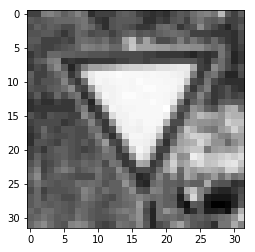

In [38]:
# Let's test one of the images to see if it looks right
print(X_train[55])
plt.imshow(X_train[55], cmap = "Greys_r")
plt.show()

In [39]:
# Save the positive images in the 'pos' directory, and create the lst file
file_path = "/Users/johnreid/capstone/cascade/"

pic_num = 1
for img in X_train:
    try:
        line = str(pic_num) + '.jpg' + ' 1 0 0 32 32\n'
        with open(file_path + 'pos/pos.lst','a') as f:
            f.write(line)
        plt.imsave(file_path + "pos/"+str(pic_num)+".jpg",img, cmap = "Greys_r")
        pic_num += 1

    except Exception as e:
        print(str(e))  

### Training the classifier
I used the following shell commands

```
mkdir data 
opencv_createsamples -info pos/pos.lst -num 5000 -w 32 -h 32 -vec positives.vec
opencv_traincascade -data data -vec positives.vec -bg bg.txt -numPos 1000 -numNeg 900 -numStages 10 -w 32 -h 32
```

Since this took a very long time to run for even two stages, I interrupted the execution and combined the stages as follows:
```
opencv_traincascade -data data -vec positives.vec -bg bg.txt -numPos 1000 -numNeg 900 -numStages 2 -w 32 -h 32
```

Remember to rename your cascade.xml something informative. In my case, I renamed cascade.xml to multiclass_2stage_cascade.xml


### Testing the classifier

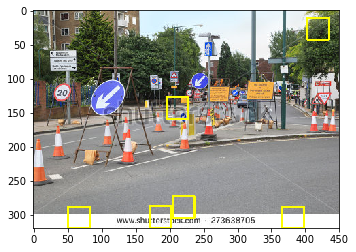

In [38]:
sign_img = cv2.imread("/Users/johnreid/capstone/pics/traffic_sign_many.jpg")
sign_img = cv2.cvtColor(sign_img, cv2.COLOR_BGR2RGB)

stopsign_cascade = cv2.CascadeClassifier('data/traffic_sign_2stage_cascade.xml')

gray = cv2.cvtColor(sign_img, cv2.COLOR_BGR2GRAY)
signs = stopsign_cascade.detectMultiScale(gray, 50, 50)

for (x,y,w,h) in signs:
    cv2.rectangle(sign_img,(x,y),(x+w,y+h),(255,255,0),2)  
plt.imshow(sign_img)
plt.show()

It looks like our classifier has failed to recognize the sign. With other images we obtain similar results. 
One problem is that our cascade only has two levels (and that took ~1.5 hours to train on my MacBook Air). 
In the following section, we will try to train a classifier for a single image

# Attempt 2: Single-class classifier

In this section, we will train a single class classifier using a stop sign. This means that our classifier should only be able to recognize stop signs; all other traffic signs will not be detected. Hopefully this should give better results.

We will use a single positive image (shown below), and use OpenCV's create_samples function to automatically generate a number of positive samples. 

    opencv_createsamples -img stopsign.jpg -bg bg.txt -info info/info.lst -pngoutput info -maxxangle 0.5 -maxyangle 0.5 -maxzangle 0.5 -num 1950
    
    opencv_createsamples -info info/info.lst -num 1950 -w 20 -h 20 -vec positives.vec
    
    opencv_traincascade -data data -vec positives.vec -bg bg.txt -numPos 1800 -numNeg 900 -numStages 17 -w 20 -h 20
    
    mv /data/cascade.xml /data/singleclass_17stage_cascade.xml

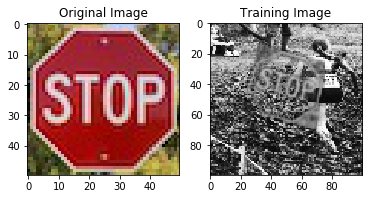

In [40]:
stop_sign = cv2.imread("/Users/johnreid/capstone/pics/stopsign.jpg")
stop_sign = cv2.cvtColor(stop_sign, cv2.COLOR_BGR2RGB)

positive_img = cv2.imread("/Users/johnreid/capstone/pics/training_img.jpg")
positive_img = cv2.cvtColor(positive_img, cv2.COLOR_BGR2RGB)

fig = plt.figure()
a=fig.add_subplot(1,2,1)
plt.imshow(stop_sign)
a.set_title('Original Image')

b=fig.add_subplot(1,2,2)
plt.imshow(positive_img)
b.set_title('Training Image')

plt.show()

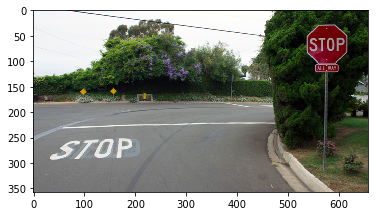

In [44]:
stopsign_cascade = cv2.CascadeClassifier('data/singleclass_17stage_cascade.xml')
test_img = cv2.imread("/Users/johnreid/capstone/pics/stopsign_2.png")
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)
signs = stopsign_cascade.detectMultiScale(gray, 50, 50)

for (x,y,w,h) in signs:
    cv2.rectangle(test_img,(x,y),(x+w,y+h),(255,255,0),2)  
plt.imshow(test_img)
plt.show()

As before, the cascade has failed to detect the stop sign appropriately. This could be because the original positive image contained noise, or we did not train it long enough, or we used too few samples in training. 